# Notebook 26 - Robustesse & Analyse Régionale de l'IMD

**Objectifs :**
1. Enrichir les données IMD avec les informations régionales et départementales
2. Produire des statistiques agrégées par région et département
3. Valider la robustesse des résultats (bootstrap CI, sensibilité aux poids, influence des outliers)
4. Identifier les déserts de mobilité par région et corrélats territoriaux

**Données :** NB21 (`imd_classement.csv`), NB22 (`profil_complet_villes.csv`), NB25 (`weights_comparison.csv`), `systems_catalog.csv`


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr, bootstrap
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import os, sys

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Output directories
OUT_DIR  = '../../output/26_Robustesse_Regionale/'
FIG_DIR  = OUT_DIR + 'figures/'
CSV_DIR  = OUT_DIR + 'tables_csv/'
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'figure.dpi': 150,
    'figure.facecolor': 'white',
})
print('✓ Setup OK')

✓ Setup OK


## 1. Chargement & Enrichissement des Données

In [2]:
# --- IMD classement (NB21) ---
imd = pd.read_csv('../../output/21_Classement_Villes_Mobilite_Douce/tables_csv/imd_classement.csv')

# --- Profil socioéconomique complet (NB22) ---
prof = pd.read_csv('../../output/22_Profil_Socioeconomique_Mobilite/tables_csv/profil_complet_villes.csv')

# --- Systems catalog (region + department) ---
cat = pd.read_csv('../../data/gbfs_france/systems_catalog.csv', encoding='utf-8')

# --- Weights comparison (NB25) ---
weights_df = pd.read_csv('../../output/25_Optimisation_Poids_IMD/tables_csv/weights_comparison.csv')

print(f'IMD: {imd.shape[0]} villes')
print(f'Profil: {prof.shape[0]} villes')
print(f'Catalog: {cat.shape[0]} systèmes, {cat["city"].nunique()} villes uniques')
print()
print('Régions disponibles:', sorted(cat['region'].dropna().unique()))

IMD: 62 villes
Profil: 62 villes
Catalog: 142 systèmes, 110 villes uniques

Régions disponibles: ['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Corse', 'Grand Est', 'Guadeloupe', 'Hauts-de-France', 'La Réunion', 'National', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', "Provence-Alpes-Côte d'Azur", 'Île-de-France']


In [3]:
# --- Merge region/department into IMD data ---
# Deduplicate catalog: keep first occurrence per city
cat_dedup = cat.drop_duplicates(subset='city', keep='first')[['city', 'region', 'department']]

# Manual mapping for cities whose name differs between IMD and catalog
# 'La Réunion' in IMD → catalog has 'Saint-Pierre...' with region='La Réunion'
manual_mappings = [
    {'city': 'La Réunion', 'region': 'La Réunion', 'department': 'La Réunion'},
]
manual_df = pd.DataFrame(manual_mappings)
cat_dedup = pd.concat([cat_dedup, manual_df], ignore_index=True)

# Merge
df = prof.merge(cat_dedup, on='city', how='left')

matched = df['region'].notna().sum()
print(f'Villes avec région: {matched}/{len(df)}')
print(f'Sans région: {df[df["region"].isna()]["city"].tolist()}')
print()
print('Distribution par région:')
print(df['region'].value_counts().to_string())

Villes avec région: 62/62
Sans région: []

Distribution par région:
region
Nouvelle-Aquitaine            9
Pays de la Loire              9
Auvergne-Rhône-Alpes          8
Grand Est                     8
Bretagne                      5
Occitanie                     5
Hauts-de-France               5
Bourgogne-Franche-Comté       4
Normandie                     3
Provence-Alpes-Côte d'Azur    2
Île-de-France                 2
Guadeloupe                    1
La Réunion                    1


## 2. Analyse Régionale

In [4]:
# --- Stats IMD par région ---
region_stats = (
    df.groupby('region')
    .agg(
        n_villes=('city', 'count'),
        IMD_mean=('IMD', 'mean'),
        IMD_median=('IMD', 'median'),
        IMD_std=('IMD', 'std'),
        IMD_min=('IMD', 'min'),
        IMD_max=('IMD', 'max'),
        n_deserts=('quadrant', lambda x: (x == "Déserts de Mobilité\nMal Équipées").sum()),
        n_favorisees=('quadrant', lambda x: (x == "Villes Favorisées\nBien Équipées").sum()),
        IES_mean=('IES', 'mean'),
        pop_mean=('population', 'mean'),
    )
    .round(3)
    .sort_values('IMD_mean', ascending=False)
    .reset_index()
)

# Show unique quadrant values to fix labels
print('Quadrant values:', df['quadrant'].unique())

Quadrant values: ['Villes Favorisées\nBien Équipées' 'Mobilité Inclusive ★'
 'Sous-Investissement' 'Désert de Mobilité Sociale ⚠']


In [5]:
# --- Fix quadrant categorization ---
def classify_quadrant(q):
    if q is None or (isinstance(q, float) and np.isnan(q)):
        return 'Inconnu'
    q = str(q)
    if 'Désert' in q or 'Desert' in q or 'Mal' in q:
        return 'Désert'
    elif 'Favoris' in q or 'Bien' in q:
        return 'Favorisée'
    elif 'Inclusive' in q:
        return 'Inclusive'
    elif 'Sous' in q:
        return 'Sous-investie'
    return q

df['quadrant_simple'] = df['quadrant'].apply(classify_quadrant)
print('Quadrant distribution:')
print(df['quadrant_simple'].value_counts())

Quadrant distribution:
quadrant_simple
Favorisée        20
Désert           18
Sous-investie    13
Inclusive        11
Name: count, dtype: int64


In [6]:
# --- Re-compute region stats with corrected quadrant ---
region_stats = (
    df.groupby('region')
    .agg(
        n_villes=('city', 'count'),
        IMD_mean=('IMD', 'mean'),
        IMD_median=('IMD', 'median'),
        IMD_std=('IMD', 'std'),
        IMD_min=('IMD', 'min'),
        IMD_max=('IMD', 'max'),
        n_deserts=('quadrant_simple', lambda x: (x == 'Désert').sum()),
        n_favorisees=('quadrant_simple', lambda x: (x == 'Favorisée').sum()),
        IES_mean=('IES', 'mean'),
        pop_mean=('population', 'mean'),
    )
    .round(3)
    .sort_values('IMD_mean', ascending=False)
    .reset_index()
)

region_stats['pct_deserts'] = (region_stats['n_deserts'] / region_stats['n_villes'] * 100).round(1)

region_stats.to_csv(CSV_DIR + 'stats_par_region.csv', index=False)
print(region_stats[['region','n_villes','IMD_mean','IMD_std','n_deserts','pct_deserts','IES_mean']].to_string())

                        region  n_villes  IMD_mean  IMD_std  n_deserts  pct_deserts  IES_mean
0   Provence-Alpes-Côte d'Azur         2     0.541    0.302          1         50.0     1.444
1                Île-de-France         2     0.479    0.140          0          0.0     0.935
2                     Bretagne         5     0.458    0.109          0          0.0     1.070
3      Bourgogne-Franche-Comté         4     0.440    0.101          1         25.0     1.078
4              Hauts-de-France         5     0.418    0.116          3         60.0     1.106
5         Auvergne-Rhône-Alpes         8     0.416    0.123          2         25.0     0.996
6                    Occitanie         5     0.412    0.106          1         20.0     1.027
7             Pays de la Loire         9     0.407    0.143          1         11.1     0.941
8           Nouvelle-Aquitaine         9     0.397    0.156          2         22.2     0.951
9                    Grand Est         8     0.382    0.057 

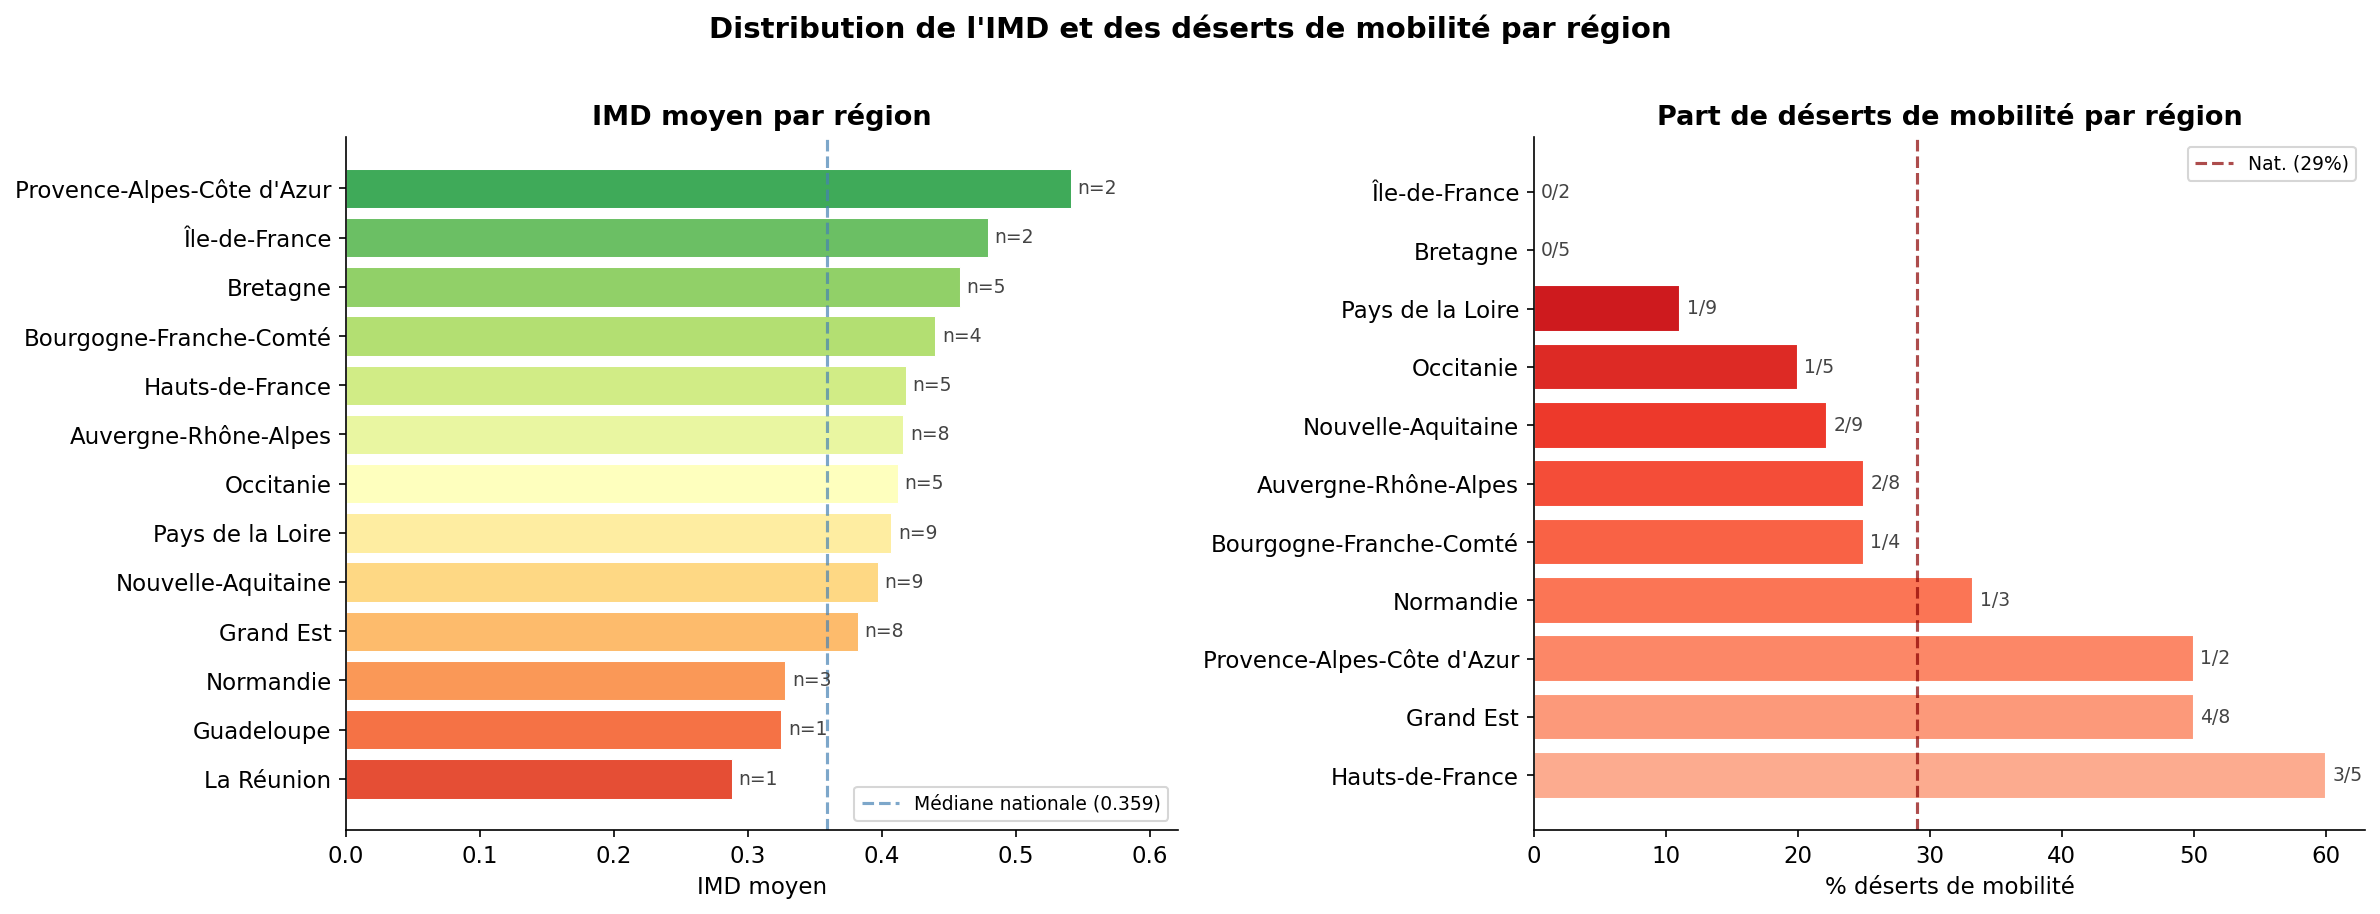

✓ Figure régionale sauvegardée


In [7]:
# --- Figure: IMD moyen par région ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: IMD mean by region (horizontal bar)
ax = axes[0]
rs_sorted = region_stats.sort_values('IMD_mean')
colors = plt.cm.RdYlGn(np.linspace(0.15, 0.85, len(rs_sorted)))
bars = ax.barh(rs_sorted['region'], rs_sorted['IMD_mean'], color=colors, edgecolor='white', linewidth=0.5)

# Add n_villes annotation
for bar, (_, row) in zip(bars, rs_sorted.iterrows()):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'n={row["n_villes"]}', va='center', ha='left', fontsize=9, color='#444')

ax.axvline(df['IMD'].median(), color='steelblue', linestyle='--', alpha=0.7, label=f'Médiane nationale ({df["IMD"].median():.3f})')
ax.set_xlabel('IMD moyen', fontsize=11)
ax.set_title('IMD moyen par région', fontweight='bold')
ax.legend(fontsize=9)
ax.set_xlim(0, rs_sorted['IMD_mean'].max() + 0.08)
ax.spines[['top','right']].set_visible(False)

# Right: % déserts par région
ax = axes[1]
rs_sorted2 = region_stats[region_stats['n_villes'] >= 2].sort_values('pct_deserts', ascending=False)
colors2 = plt.cm.Reds(np.linspace(0.3, 0.85, len(rs_sorted2)))
ax.barh(rs_sorted2['region'], rs_sorted2['pct_deserts'], color=colors2, edgecolor='white')
for i, (_, row) in enumerate(rs_sorted2.iterrows()):
    ax.text(row['pct_deserts'] + 0.5, i, f'{row["n_deserts"]}/{row["n_villes"]}',
            va='center', fontsize=9, color='#444')
ax.axvline(100 * df['quadrant_simple'].eq('Désert').mean(), color='darkred', linestyle='--',
           alpha=0.7, label=f'Nat. ({100*df["quadrant_simple"].eq("Désert").mean():.0f}%)')
ax.set_xlabel('% déserts de mobilité', fontsize=11)
ax.set_title('Part de déserts de mobilité par région', fontweight='bold')
ax.legend(fontsize=9)
ax.spines[['top','right']].set_visible(False)

plt.suptitle('Distribution de l\'IMD et des déserts de mobilité par région',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_regional_imd.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure régionale sauvegardée')

In [8]:
# --- Stats par département ---
dept_stats = (
    df.groupby(['department', 'region'])
    .agg(
        n_villes=('city', 'count'),
        IMD_mean=('IMD', 'mean'),
        IMD_median=('IMD', 'median'),
        n_deserts=('quadrant_simple', lambda x: (x == 'Désert').sum()),
        IES_mean=('IES', 'mean'),
    )
    .round(3)
    .reset_index()
    .sort_values('IMD_mean', ascending=False)
)

dept_stats.to_csv(CSV_DIR + 'stats_par_departement.csv', index=False)
print(f'Départements représentés: {len(dept_stats)}')
print(dept_stats.to_string())

Départements représentés: 52
               department                      region  n_villes  IMD_mean  IMD_median  n_deserts  IES_mean
7        Bouches-du-Rhône  Provence-Alpes-Côte d'Azur         1     0.755       0.755          0     2.039
43                  Rhône        Auvergne-Rhône-Alpes         1     0.660       0.660          0     1.423
26        Ille-et-Vilaine                    Bretagne         1     0.621       0.621          0     1.362
37                   Nord             Hauts-de-France         1     0.607       0.607          0     1.605
38                  Paris               Île-de-France         1     0.578       0.578          0     1.037
19                Gironde          Nouvelle-Aquitaine         2     0.573       0.573          0     1.339
22          Haute-Garonne                   Occitanie         1     0.562       0.562          0     1.275
45  Territoire de Belfort     Bourgogne-Franche-Comté         1     0.562       0.562          0     1.427
2       

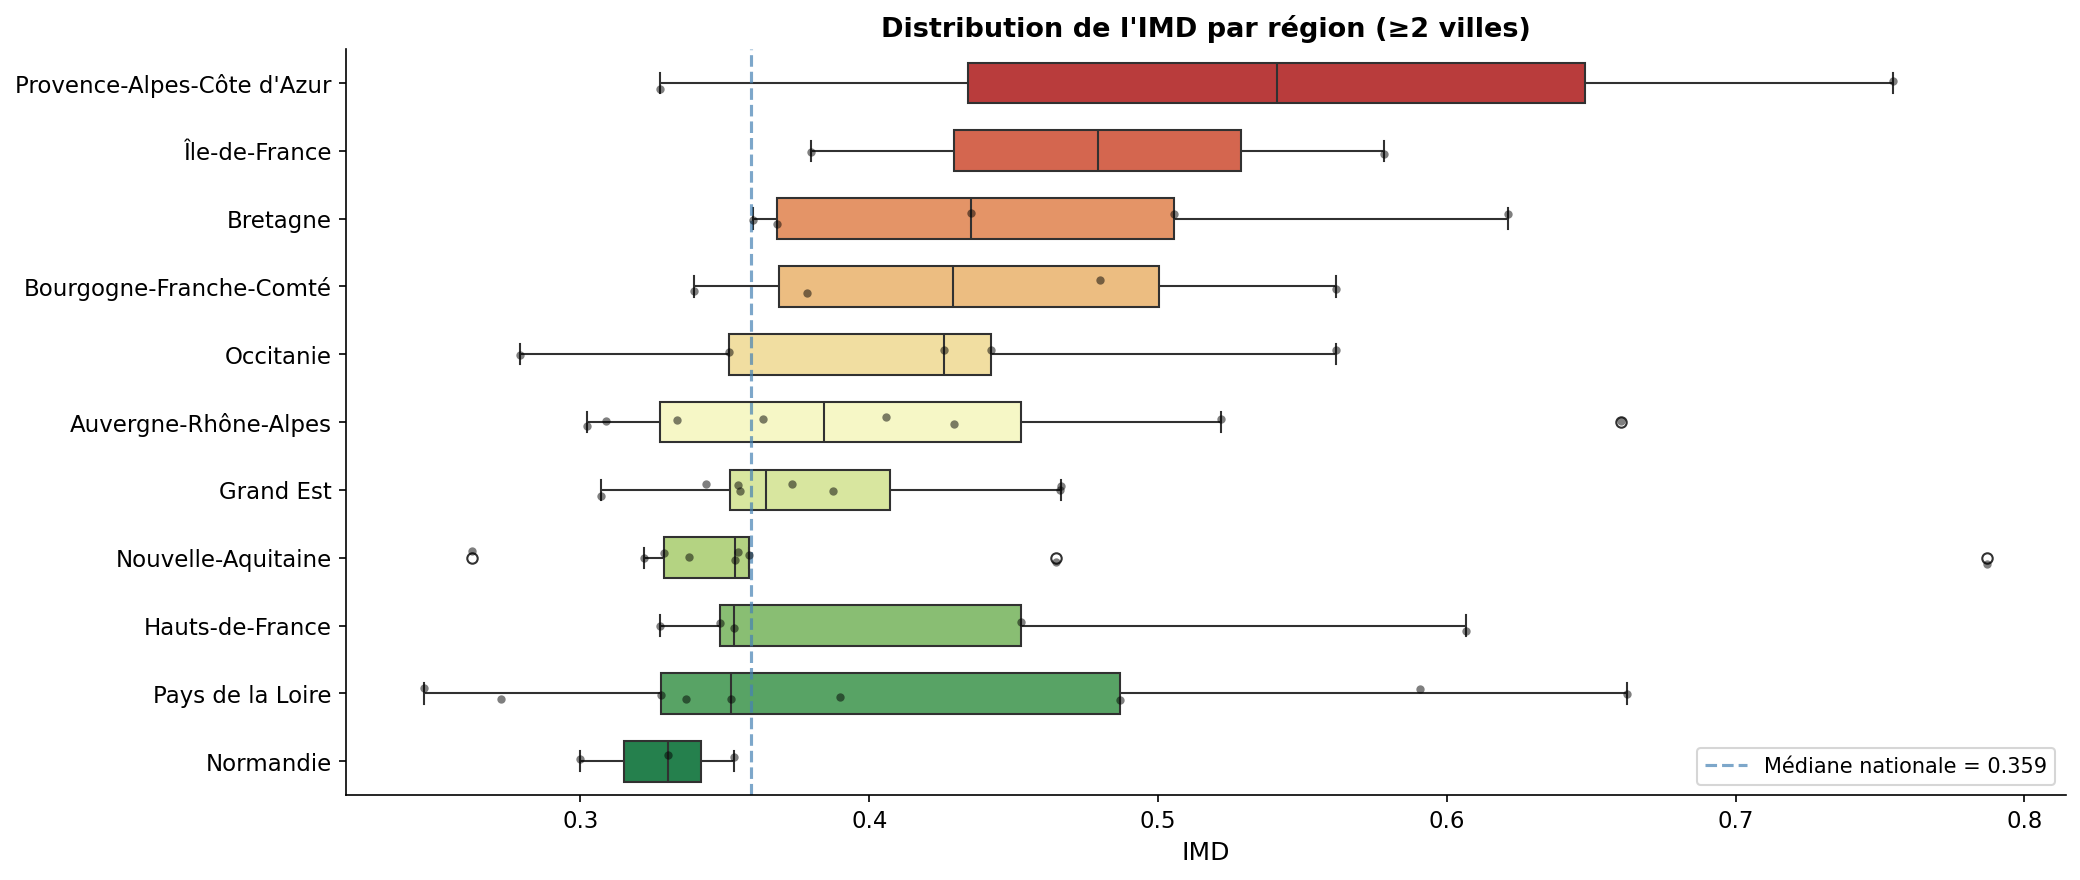

✓ Boxplot régional sauvegardé


In [9]:
# --- Figure: Boxplot IMD par région (>= 2 villes) ---
regions_min2 = region_stats[region_stats['n_villes'] >= 2]['region'].tolist()
df_min2 = df[df['region'].isin(regions_min2)].copy()

# Sort regions by median IMD
order = df_min2.groupby('region')['IMD'].median().sort_values(ascending=False).index

fig, ax = plt.subplots(figsize=(14, 6))
palette = sns.color_palette('RdYlGn', len(order))

sns.boxplot(data=df_min2, y='region', x='IMD', order=order, palette=palette,
            width=0.6, flierprops=dict(marker='o', markersize=5), ax=ax)
sns.stripplot(data=df_min2, y='region', x='IMD', order=order, color='k', alpha=0.5,
              size=4, jitter=True, ax=ax)

ax.axvline(df['IMD'].median(), color='steelblue', linestyle='--', alpha=0.7,
           label=f'Médiane nationale = {df["IMD"].median():.3f}')
ax.set_xlabel('IMD', fontsize=12)
ax.set_ylabel('')
ax.set_title('Distribution de l\'IMD par région (≥2 villes)', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_boxplot_imd_region.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Boxplot régional sauvegardé')

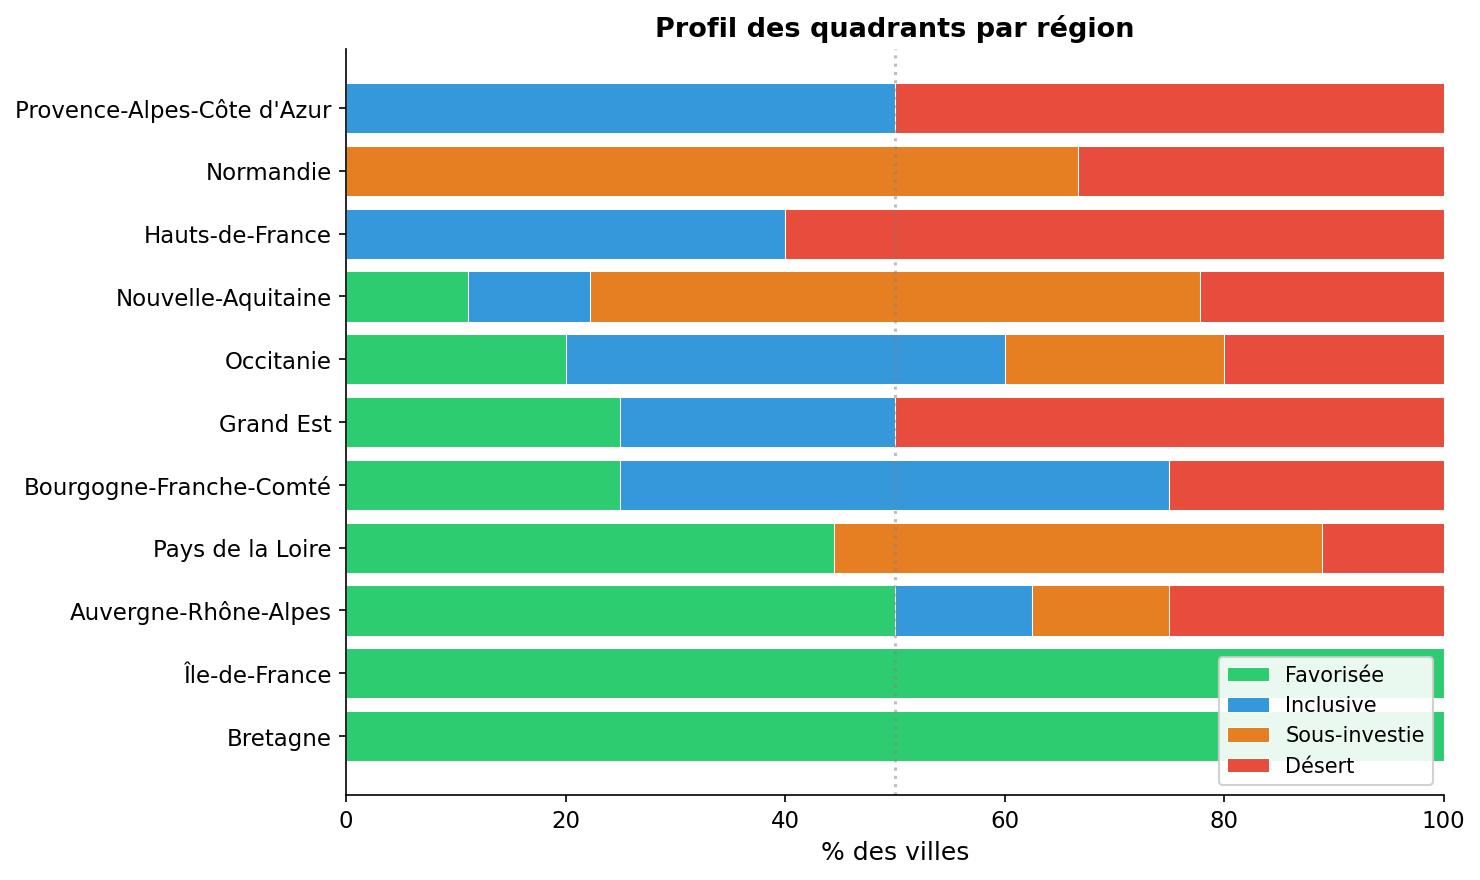

✓ Heatmap quadrant sauvegardée


In [10]:
# --- Figure: Heatmap quadrant par région ---
regions_use = regions_min2  # regions with >= 2 cities
df_heat = df[df['region'].isin(regions_use)].copy()

quadrant_order = ['Favorisée', 'Inclusive', 'Sous-investie', 'Désert']
quad_counts = (
    df_heat.groupby(['region', 'quadrant_simple'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=[q for q in quadrant_order if q in df_heat['quadrant_simple'].unique()], fill_value=0)
)
# Normalize to %
quad_pct = quad_counts.div(quad_counts.sum(axis=1), axis=0) * 100
# Sort by % Favorisée
if 'Favorisée' in quad_pct.columns:
    quad_pct = quad_pct.sort_values('Favorisée', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors_quad = {'Favorisée': '#2ecc71', 'Inclusive': '#3498db', 'Sous-investie': '#e67e22', 'Désert': '#e74c3c'}

bottom = pd.Series(0.0, index=quad_pct.index)
for col in quad_pct.columns:
    if col in colors_quad:
        ax.barh(quad_pct.index, quad_pct[col], left=bottom,
                color=colors_quad[col], label=col, edgecolor='white', linewidth=0.5)
        bottom += quad_pct[col]

ax.set_xlabel('% des villes', fontsize=12)
ax.set_title('Profil des quadrants par région', fontweight='bold', fontsize=13)
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax.axvline(50, color='gray', linestyle=':', alpha=0.5)
ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_quadrant_region.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Heatmap quadrant sauvegardée')

## 3. Analyse de Robustesse

In [11]:
# === 3.1 Bootstrap Confidence Intervals for IMD ===
# For each city, compute CI on IMD rank via bootstrap resampling of the population

W_OPT = {'C1_S': 0.1839, 'C2_E': 0.0689, 'C3_D': 0.0511, 'C4_P': 0.1184, 'C5_M': 0.5776}
W_FALLBACK = {'C1_S': 0.2086, 'C2_E': 0.0782, 'C3_D': 0.0580, 'C5_M': 0.6552}  # when C4_P NaN

components = ['C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M']

def compute_imd_series(data_df, weights):
    """Compute IMD for each city given a weights dict."""
    imd_vals = []
    for _, row in data_df.iterrows():
        if pd.notna(row.get('C4_P', np.nan)):
            w = weights
            s = sum(w.get(c, 0) * row[c] for c in components if c in row)
        else:
            s = (W_FALLBACK['C1_S'] * row['C1_S'] +
                 W_FALLBACK['C2_E'] * row['C2_E'] +
                 W_FALLBACK['C3_D'] * row['C3_D'] +
                 W_FALLBACK['C5_M'] * row['C5_M'])
        imd_vals.append(s)
    return np.array(imd_vals)

# Verify against existing IMD
imd_recalc = compute_imd_series(df, W_OPT)
corr_check = np.corrcoef(imd_recalc, df['IMD'])[0,1]
print(f'Correlation IMD recalculé vs original: r={corr_check:.4f}')
print(f'MAE: {np.abs(imd_recalc - df["IMD"]).mean():.4f}')

Correlation IMD recalculé vs original: r=1.0000
MAE: 0.0000


In [12]:
# === Bootstrap Monte Carlo: N=5000 Dirichlet weight samples ===
# Sample weights from Dirichlet(α=W_OPT * K) to get uncertainty around current weights

N_BOOTSTRAP = 5000
np.random.seed(RANDOM_SEED)

n_cities = len(df)
cities = df['city'].values

# Store rank for each city in each bootstrap
ranks_matrix = np.zeros((N_BOOTSTRAP, n_cities))
imd_matrix = np.zeros((N_BOOTSTRAP, n_cities))

# Concentration parameter: higher α → tighter distribution around W_OPT
alpha_mult = 15  # moderate uncertainty
alpha_base = np.array([W_OPT['C1_S'], W_OPT['C2_E'], W_OPT['C3_D'], W_OPT['C4_P'], W_OPT['C5_M']])

data_arr = df[components].values  # (62, 5) - some NaN in C4_P col
has_c4p = df['C4_P'].notna().values

for i in range(N_BOOTSTRAP):
    # Sample weights
    w_sample = np.random.dirichlet(alpha_base * alpha_mult)
    
    # Compute IMD for each city
    imd_bs = np.zeros(n_cities)
    for j in range(n_cities):
        if has_c4p[j]:
            imd_bs[j] = np.dot(w_sample, data_arr[j])
        else:
            # Fallback: redistribute C4_P weight proportionally among others
            w4 = w_sample[3]  # C4_P weight
            w_others = w_sample[[0,1,2,4]].copy()
            w_others = w_others / w_others.sum() * (1 - w4 + w4)  # normalize
            # Actually, just redistribute C4_P weight to remaining components
            w_noc4 = w_sample[[0,1,2,4]].copy()
            total = w_noc4.sum()
            w_noc4 = w_noc4 / total if total > 0 else w_noc4
            imd_bs[j] = np.dot(w_noc4, data_arr[j, [0,1,2,4]])
    
    imd_matrix[i] = imd_bs
    ranks_matrix[i] = n_cities + 1 - pd.Series(imd_bs).rank().values  # rank 1 = best

print(f'✓ Bootstrap terminé: {N_BOOTSTRAP} itérations')

✓ Bootstrap terminé: 5000 itérations


In [13]:
# --- Bootstrap statistics per city ---
imd_ci_low  = np.percentile(imd_matrix, 2.5, axis=0)
imd_ci_high = np.percentile(imd_matrix, 97.5, axis=0)
imd_bs_mean = np.mean(imd_matrix, axis=0)
rank_ci_low  = np.percentile(ranks_matrix, 2.5, axis=0)
rank_ci_high = np.percentile(ranks_matrix, 97.5, axis=0)
rank_bs_mean = np.mean(ranks_matrix, axis=0)

# % samples where city is in top-10
pct_top10  = (ranks_matrix <= 10).mean(axis=0) * 100
pct_top20  = (ranks_matrix <= 20).mean(axis=0) * 100
pct_desert = (ranks_matrix > n_cities * 0.7).mean(axis=0) * 100  # bottom 30%

robustness_df = pd.DataFrame({
    'city': cities,
    'rang_nominal': df['rang'].values,
    'IMD_nominal': df['IMD'].values,
    'IMD_bs_mean': imd_bs_mean.round(4),
    'IMD_ci95_low': imd_ci_low.round(4),
    'IMD_ci95_high': imd_ci_high.round(4),
    'IMD_ci_width': (imd_ci_high - imd_ci_low).round(4),
    'rang_bs_mean': rank_bs_mean.round(1),
    'rang_ci95_low': rank_ci_low.round(1),
    'rang_ci95_high': rank_ci_high.round(1),
    'rang_ci_width': (rank_ci_high - rank_ci_low).round(1),
    'pct_top10': pct_top10.round(1),
    'pct_top20': pct_top20.round(1),
}).sort_values('rang_nominal')

robustness_df.to_csv(CSV_DIR + 'bootstrap_robustness.csv', index=False)
print('Top 10 avec CI bootstrap:')
print(robustness_df.head(10)[['city','rang_nominal','IMD_nominal','IMD_ci95_low','IMD_ci95_high','rang_ci95_low','rang_ci95_high','pct_top10']].to_string())

Top 10 avec CI bootstrap:
               city  rang_nominal  IMD_nominal  IMD_ci95_low  IMD_ci95_high  rang_ci95_low  rang_ci95_high  pct_top10
0          Bordeaux             1       0.7872        0.6515         0.9070            1.0             2.0      100.0
1         Marseille             2       0.7547        0.5812         0.8968            2.0             4.0       99.8
2            Nantes             3       0.6624        0.5568         0.7408            1.0             6.0       99.7
3              Lyon             4       0.6602        0.4338         0.8592            3.0            16.0       89.6
4            Rennes             5       0.6213        0.5149         0.6908            4.0             9.0       98.6
5             Lille             6       0.6067        0.5475         0.6610            3.0            10.0       98.6
6  La Roche-sur-Yon             7       0.5907        0.4578         0.6676            5.0            15.0       90.2
7             Paris           

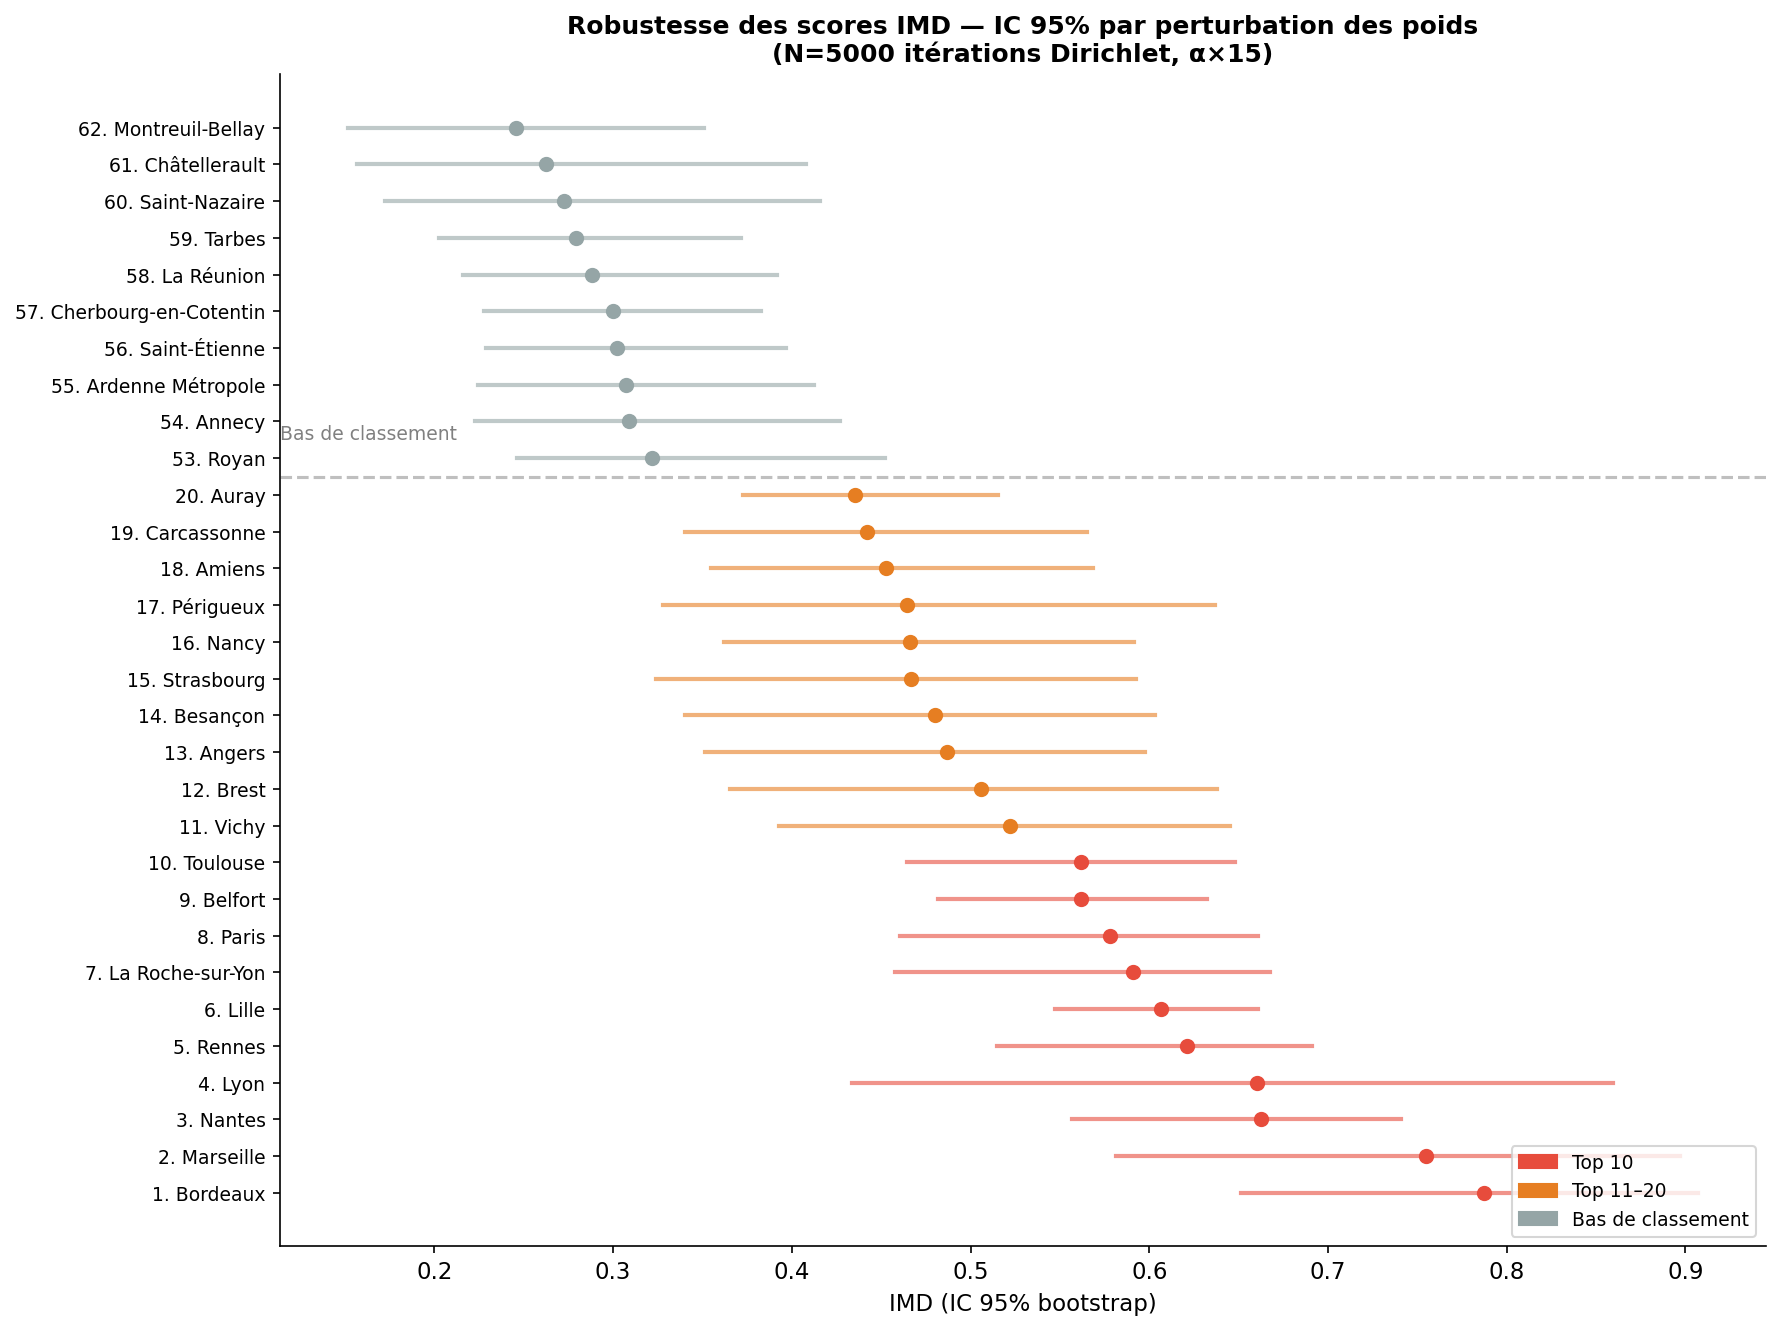

✓ Figure bootstrap CI sauvegardée


In [14]:
# --- Figure: Intervalles de confiance bootstrap sur l'IMD (top 20 + bottom 10) ---
top20 = robustness_df.head(20)
bot10 = robustness_df.tail(10)
plot_df = pd.concat([top20, bot10]).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 9))

colors_pt = ['#e74c3c' if r <= 10 else '#e67e22' if r <= 20 else '#95a5a6'
             for r in plot_df['rang_nominal']]

y_pos = range(len(plot_df))
for i, (_, row) in enumerate(plot_df.iterrows()):
    ax.plot([row['IMD_ci95_low'], row['IMD_ci95_high']], [i, i],
            color=colors_pt[i], alpha=0.6, linewidth=2)
    ax.scatter(row['IMD_nominal'], i, color=colors_pt[i], s=40, zorder=5)

ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels([f"{row['rang_nominal']}. {row['city']}" for _, row in plot_df.iterrows()],
                   fontsize=9)
ax.set_xlabel('IMD (IC 95% bootstrap)', fontsize=11)
ax.set_title(f'Robustesse des scores IMD - IC 95% par perturbation des poids\n(N={N_BOOTSTRAP} itérations Dirichlet, α×{alpha_mult})',
             fontweight='bold', fontsize=12)

# Add separator
ax.axhline(len(top20) - 0.5, color='gray', linestyle='--', alpha=0.5)
ax.text(ax.get_xlim()[0], len(top20) + 0.5, 'Bas de classement', fontsize=9, color='gray')

# Legend
handles = [
    mpatches.Patch(color='#e74c3c', label='Top 10'),
    mpatches.Patch(color='#e67e22', label='Top 11–20'),
    mpatches.Patch(color='#95a5a6', label='Bas de classement'),
]
ax.legend(handles=handles, fontsize=9, loc='lower right')
ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_bootstrap_ci.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure bootstrap CI sauvegardée')

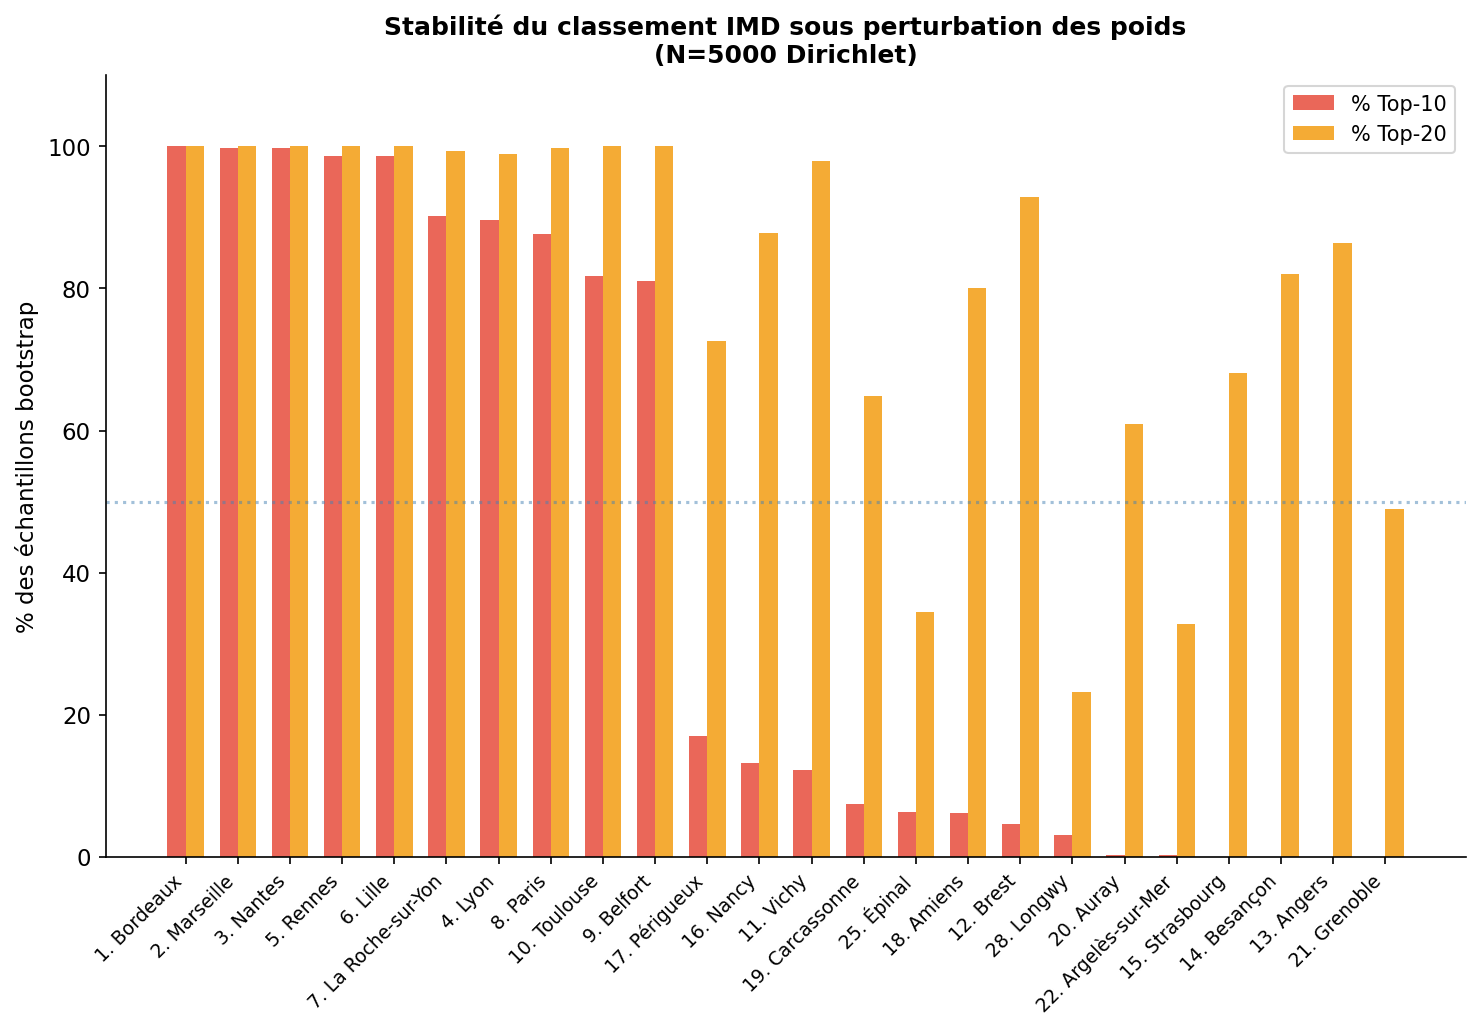

✓ Figure stabilité du rang sauvegardée


In [15]:
# --- Figure: Stabilité du rang (% dans Top-10 et Top-20) ---
stability_top20 = robustness_df[robustness_df['pct_top20'] > 20].sort_values('pct_top10', ascending=False)

fig, ax = plt.subplots(figsize=(10, 7))

x = np.arange(len(stability_top20))
w = 0.35
b1 = ax.bar(x - w/2, stability_top20['pct_top10'], w, label='% Top-10', color='#e74c3c', alpha=0.85)
b2 = ax.bar(x + w/2, stability_top20['pct_top20'], w, label='% Top-20', color='#f39c12', alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(
    [f"{row['rang_nominal']}. {row['city']}" for _, row in stability_top20.iterrows()],
    rotation=45, ha='right', fontsize=9
)
ax.set_ylabel('% des échantillons bootstrap', fontsize=11)
ax.set_title('Stabilité du classement IMD sous perturbation des poids\n(N=5000 Dirichlet)',
             fontweight='bold', fontsize=12)
ax.legend(fontsize=10)
ax.axhline(50, color='steelblue', linestyle=':', alpha=0.5, label='50%')
ax.set_ylim(0, 110)
ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_rank_stability.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure stabilité du rang sauvegardée')

## 4. Analyse de Sensibilité OAT (One-At-a-Time)

In [16]:
# === OAT: vary each weight ±20%, ±40% and measure impact on Spearman rank correlation ===

imd_nominal = df['IMD'].values
rank_nominal = pd.Series(imd_nominal).rank(ascending=False).values

perturbations = [-0.40, -0.20, +0.20, +0.40]
oat_results = []

weight_names = ['C1_S (Couverture)', 'C2_E (Électricité)', 'C3_D (Densité)', 'C4_P (Part modale)', 'C5_M (Multimodalité)']
w_base = np.array([W_OPT['C1_S'], W_OPT['C2_E'], W_OPT['C3_D'], W_OPT['C4_P'], W_OPT['C5_M']])
w_keys = ['C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M']

for k_idx, (k, kname) in enumerate(zip(w_keys, weight_names)):
    for delta in perturbations:
        w_new = w_base.copy()
        w_new[k_idx] = w_base[k_idx] * (1 + delta)
        # Renormalize
        w_new = w_new / w_new.sum()
        w_dict = dict(zip(w_keys, w_new))
        
        imd_new = compute_imd_series(df, w_dict)
        rho, _ = spearmanr(imd_nominal, imd_new)
        rank_new = pd.Series(imd_new).rank(ascending=False).values
        rank_mae = np.abs(rank_nominal - rank_new).mean()
        
        oat_results.append({
            'composante': kname,
            'w_key': k,
            'delta': f'{delta:+.0%}',
            'w_original': w_base[k_idx],
            'w_new': w_new[k_idx],
            'rho_nominal': rho,
            'rank_mae': rank_mae,
        })

oat_df = pd.DataFrame(oat_results)
oat_df.to_csv(CSV_DIR + 'sensitivity_oat.csv', index=False)
print('OAT Sensitivity (Spearman ρ avec classement nominal):')
print(oat_df[['composante','delta','rho_nominal','rank_mae']].to_string())

OAT Sensitivity (Spearman ρ avec classement nominal):
              composante delta  rho_nominal  rank_mae
0      C1_S (Couverture)  -40%     0.987950  1.919355
1      C1_S (Couverture)  -20%     0.996462  0.983871
2      C1_S (Couverture)  +20%     0.995052  1.016129
3      C1_S (Couverture)  +40%     0.987195  1.887097
4     C2_E (Électricité)  -40%     0.992987  0.854839
5     C2_E (Électricité)  -20%     0.996865  0.532258
6     C2_E (Électricité)  +20%     0.998879  0.387097
7     C2_E (Électricité)  +40%     0.997721  0.661290
8         C3_D (Densité)  -40%     0.997771  0.725806
9         C3_D (Densité)  -20%     0.998804  0.435484
10        C3_D (Densité)  +20%     0.999333  0.274194
11        C3_D (Densité)  +40%     0.997897  0.661290
12    C4_P (Part modale)  -40%     0.982184  1.919355
13    C4_P (Part modale)  -20%     0.995203  0.919355
14    C4_P (Part modale)  +20%     0.996336  0.887097
15    C4_P (Part modale)  +40%     0.988353  1.758065
16  C5_M (Multimodalité)  -4

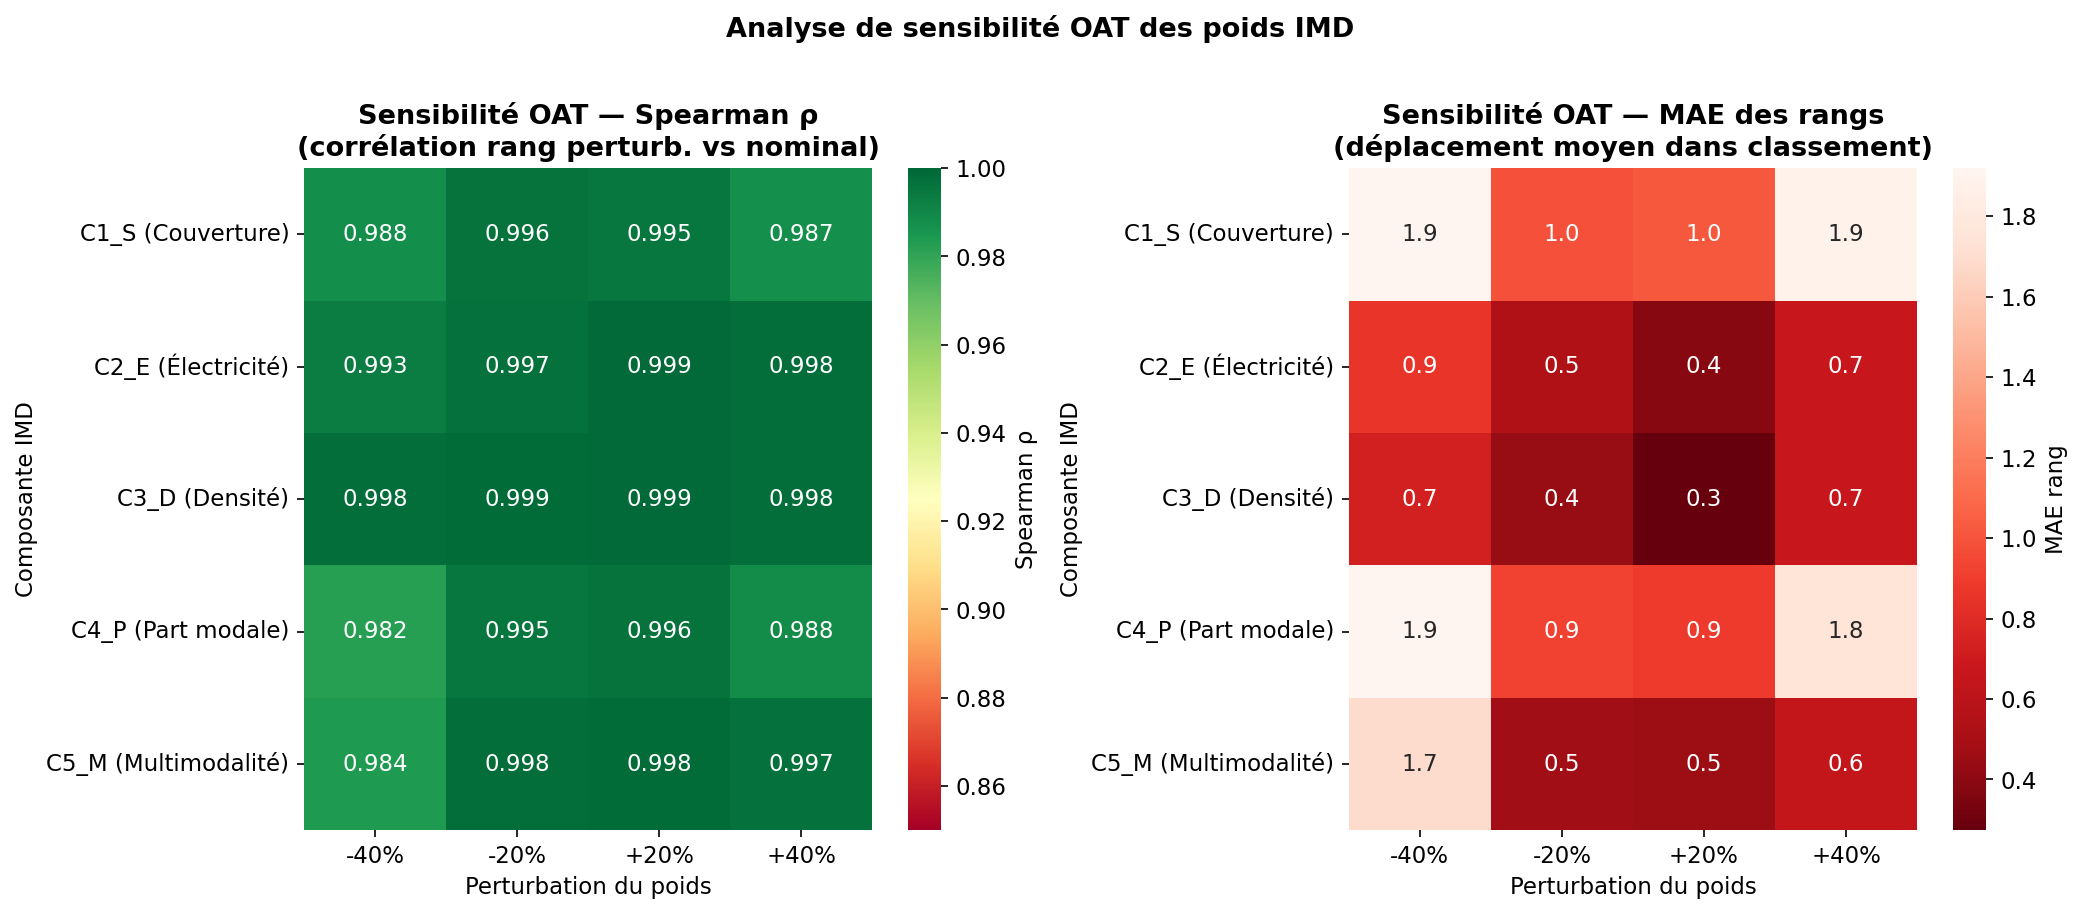

✓ Figure OAT sauvegardée


In [17]:
# --- Figure OAT ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pivot for heatmap
pivot_rho = oat_df.pivot(index='composante', columns='delta', values='rho_nominal')
pivot_mae = oat_df.pivot(index='composante', columns='delta', values='rank_mae')

delta_order = ['-40%', '-20%', '+20%', '+40%']
for col in delta_order:
    if col not in pivot_rho.columns:
        pivot_rho[col] = np.nan
        pivot_mae[col] = np.nan
pivot_rho = pivot_rho[delta_order]
pivot_mae = pivot_mae[delta_order]

sns.heatmap(pivot_rho, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0.85, vmax=1.0, ax=axes[0],
            cbar_kws={'label': 'Spearman ρ'})
axes[0].set_title('Sensibilité OAT - Spearman ρ\n(corrélation rang perturb. vs nominal)', fontweight='bold')
axes[0].set_ylabel('Composante IMD')
axes[0].set_xlabel('Perturbation du poids')

sns.heatmap(pivot_mae, annot=True, fmt='.1f', cmap='Reds_r',
            ax=axes[1], cbar_kws={'label': 'MAE rang'})
axes[1].set_title('Sensibilité OAT - MAE des rangs\n(déplacement moyen dans classement)', fontweight='bold')
axes[1].set_ylabel('Composante IMD')
axes[1].set_xlabel('Perturbation du poids')

plt.suptitle('Analyse de sensibilité OAT des poids IMD', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_sensitivity_oat.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure OAT sauvegardée')

## 5. Robustesse des Corrélations Socioéconomiques

In [18]:
# === Bootstrap des corrélations de Spearman ===
# Test if socioeconomic correlations are stable across bootstrap resamples

socio_vars = {
    'part_diplomes_sup': 'Part diplômés sup.',
    'part_sans_voiture': 'Part sans voiture',
    'part_velo': 'Part vélo domicile-travail',
    'taux_chomage': 'Taux de chômage',
    'revenu_median_uc': 'Revenu médian UC',
    'part_cadres': 'Part cadres',
    'taux_pauvrete': 'Taux de pauvreté',
    'infra_cyclable_km_per_km2': 'Infra cyclable /km²',
    'fub_score_2023': 'Score FUB 2023',
}

N_BS_CORR = 2000
np.random.seed(RANDOM_SEED)

corr_results = []
for var, label in socio_vars.items():
    y = df[var].values
    x = df['IMD'].values
    
    # Mask NaN
    mask = ~np.isnan(x) & ~np.isnan(y)
    n_valid = mask.sum()
    x_v, y_v = x[mask], y[mask]
    
    if n_valid < 10:
        continue
    
    # Nominal correlation
    rho_nom, pval_nom = spearmanr(x_v, y_v)
    
    # Bootstrap CI
    rho_bs = []
    for _ in range(N_BS_CORR):
        idx = np.random.choice(n_valid, n_valid, replace=True)
        r, _ = spearmanr(x_v[idx], y_v[idx])
        rho_bs.append(r)
    rho_bs = np.array(rho_bs)
    
    corr_results.append({
        'variable': label,
        'n': n_valid,
        'rho': rho_nom,
        'pvalue': pval_nom,
        'sig': '***' if pval_nom < 0.001 else '**' if pval_nom < 0.01 else '*' if pval_nom < 0.05 else '',
        'bs_ci_low': np.percentile(rho_bs, 2.5),
        'bs_ci_high': np.percentile(rho_bs, 97.5),
        'bs_ci_width': np.percentile(rho_bs, 97.5) - np.percentile(rho_bs, 2.5),
        'sign_stable': (np.percentile(rho_bs, 2.5) > 0) or (np.percentile(rho_bs, 97.5) < 0),
    })

corr_df = pd.DataFrame(corr_results).sort_values('rho', ascending=False)
corr_df.to_csv(CSV_DIR + 'correlations_bootstrap.csv', index=False)
print('Corrélations Spearman avec IC 95% bootstrap:')
print(corr_df[['variable','n','rho','sig','bs_ci_low','bs_ci_high','sign_stable']].to_string())

Corrélations Spearman avec IC 95% bootstrap:
                     variable   n       rho  sig  bs_ci_low  bs_ci_high  sign_stable
7         Infra cyclable /km²  45  0.544353  ***   0.288703    0.741967         True
0          Part diplômés sup.  62  0.530023  ***   0.316314    0.698706         True
5                 Part cadres  62  0.519713  ***   0.286963    0.692794         True
8              Score FUB 2023  34  0.472783   **   0.104233    0.770205         True
1           Part sans voiture  62  0.435966  ***   0.211647    0.629775         True
2  Part vélo domicile-travail  62  0.428997  ***   0.191839    0.620923         True
4            Revenu médian UC  62  0.295166    *   0.037760    0.526015         True
6            Taux de pauvreté  62 -0.172037       -0.420933    0.099946        False
3             Taux de chômage  62 -0.269836    *  -0.513527    0.009212        False


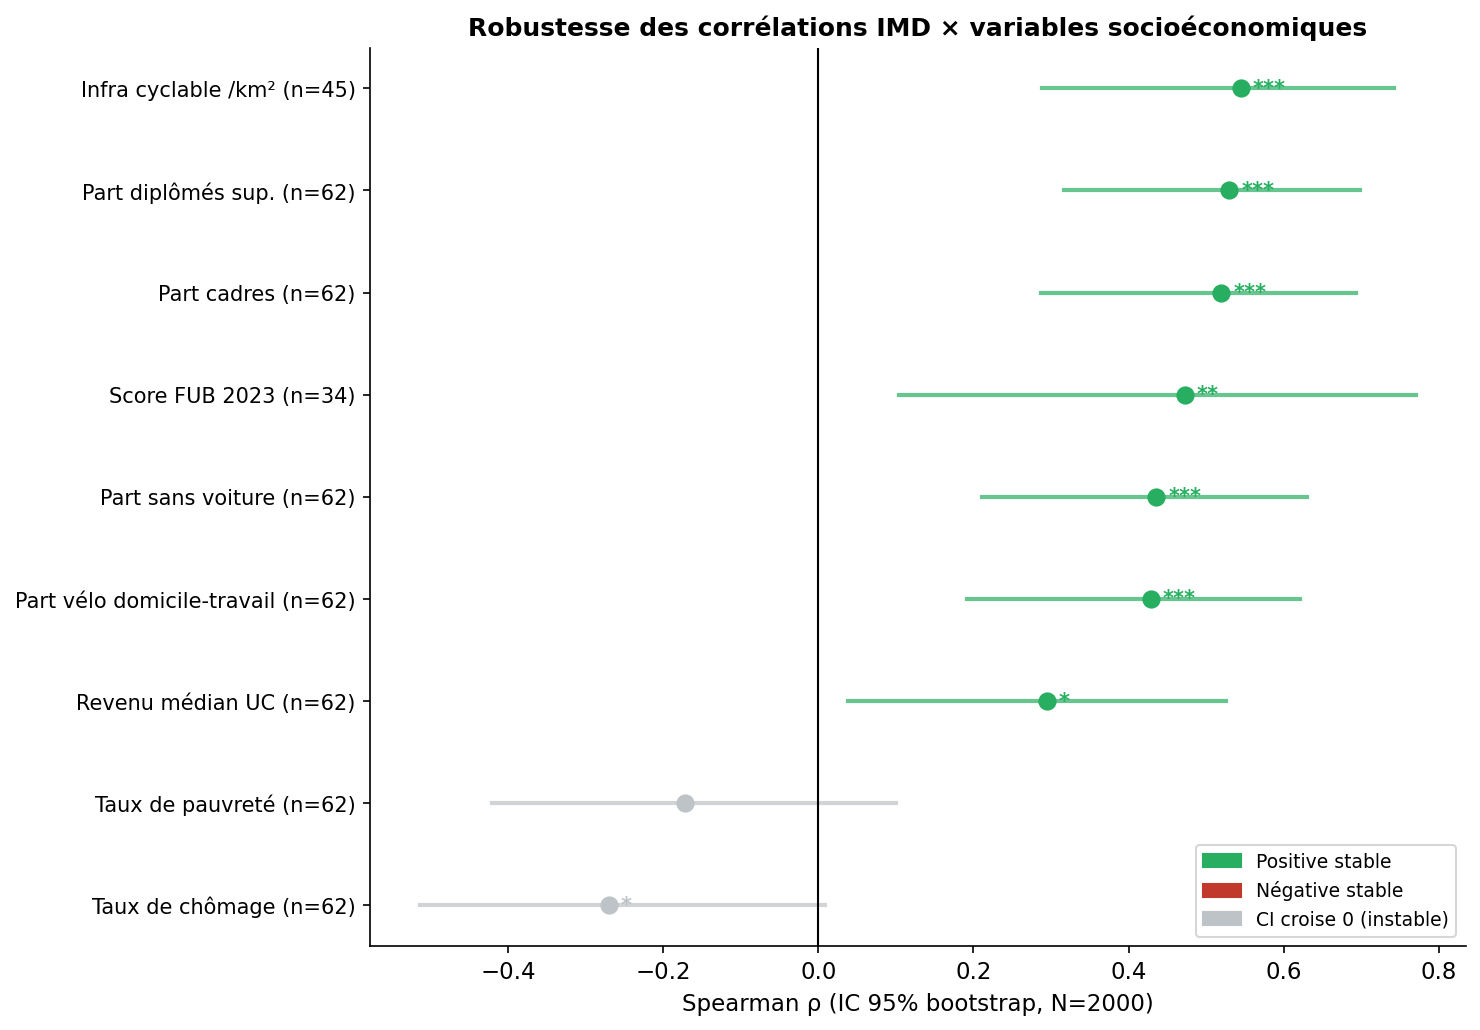

✓ Figure corrélations bootstrap sauvegardée


In [19]:
# --- Figure: corrélations avec IC bootstrap ---
fig, ax = plt.subplots(figsize=(10, 7))

corr_sorted = corr_df.sort_values('rho')
y_pos = range(len(corr_sorted))
colors_c = ['#27ae60' if row['sign_stable'] and row['rho'] > 0
            else '#c0392b' if row['sign_stable'] and row['rho'] < 0
            else '#bdc3c7'
            for _, row in corr_sorted.iterrows()]

for i, (_, row) in enumerate(corr_sorted.iterrows()):
    ax.plot([row['bs_ci_low'], row['bs_ci_high']], [i, i], color=colors_c[i], linewidth=2, alpha=0.7)
    ax.scatter(row['rho'], i, color=colors_c[i], s=60, zorder=5)
    # Add sig stars
    if row['sig']:
        ax.text(row['rho'] + 0.015, i, row['sig'], va='center', fontsize=10, color=colors_c[i], fontweight='bold')

ax.axvline(0, color='black', linewidth=1)
ax.set_yticks(range(len(corr_sorted)))
ax.set_yticklabels([f"{row['variable']} (n={row['n']})" for _, row in corr_sorted.iterrows()], fontsize=10)
ax.set_xlabel('Spearman ρ (IC 95% bootstrap, N=2000)', fontsize=11)
ax.set_title('Robustesse des corrélations IMD × variables socioéconomiques',
             fontweight='bold', fontsize=12)

handles = [
    mpatches.Patch(color='#27ae60', label='Positive stable'),
    mpatches.Patch(color='#c0392b', label='Négative stable'),
    mpatches.Patch(color='#bdc3c7', label='CI croise 0 (instable)'),
]
ax.legend(handles=handles, fontsize=9, loc='lower right')
ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_correlations_bootstrap.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure corrélations bootstrap sauvegardée')

## 6. Analyse de la Complétude des Données

In [20]:
# === Data completeness analysis ===
key_vars = ['C1_S', 'C2_E', 'C3_D', 'C4_P', 'C5_M',
            'revenu_median_uc', 'taux_chomage', 'part_cadres',
            'part_diplomes_sup', 'part_sans_voiture', 'taux_pauvrete',
            'part_velo', 'fub_score_2023', 'emp_part_velo_2019',
            'infra_cyclable_km', 'gtfs_stops_within_300m_pct',
            'eco_avg_daily_bike_counts', 'baac_accidents_cyclistes_per_100k']

completeness = pd.DataFrame({
    'variable': key_vars,
    'n_valid': [df[v].notna().sum() for v in key_vars],
    'n_missing': [df[v].isna().sum() for v in key_vars],
    'pct_valid': [(df[v].notna().mean() * 100).round(1) for v in key_vars],
}).sort_values('pct_valid', ascending=True)

completeness.to_csv(CSV_DIR + 'data_completeness.csv', index=False)
print(completeness.to_string())

                             variable  n_valid  n_missing  pct_valid
15         gtfs_stops_within_300m_pct        0         62        0.0
16          eco_avg_daily_bike_counts       26         36       41.9
12                     fub_score_2023       34         28       54.8
14                  infra_cyclable_km       45         17       72.6
17  baac_accidents_cyclistes_per_100k       46         16       74.2
13                 emp_part_velo_2019       46         16       74.2
3                                C4_P       59          3       95.2
0                                C1_S       62          0      100.0
7                         part_cadres       62          0      100.0
6                        taux_chomage       62          0      100.0
5                    revenu_median_uc       62          0      100.0
4                                C5_M       62          0      100.0
11                          part_velo       62          0      100.0
10                      taux_pauvr

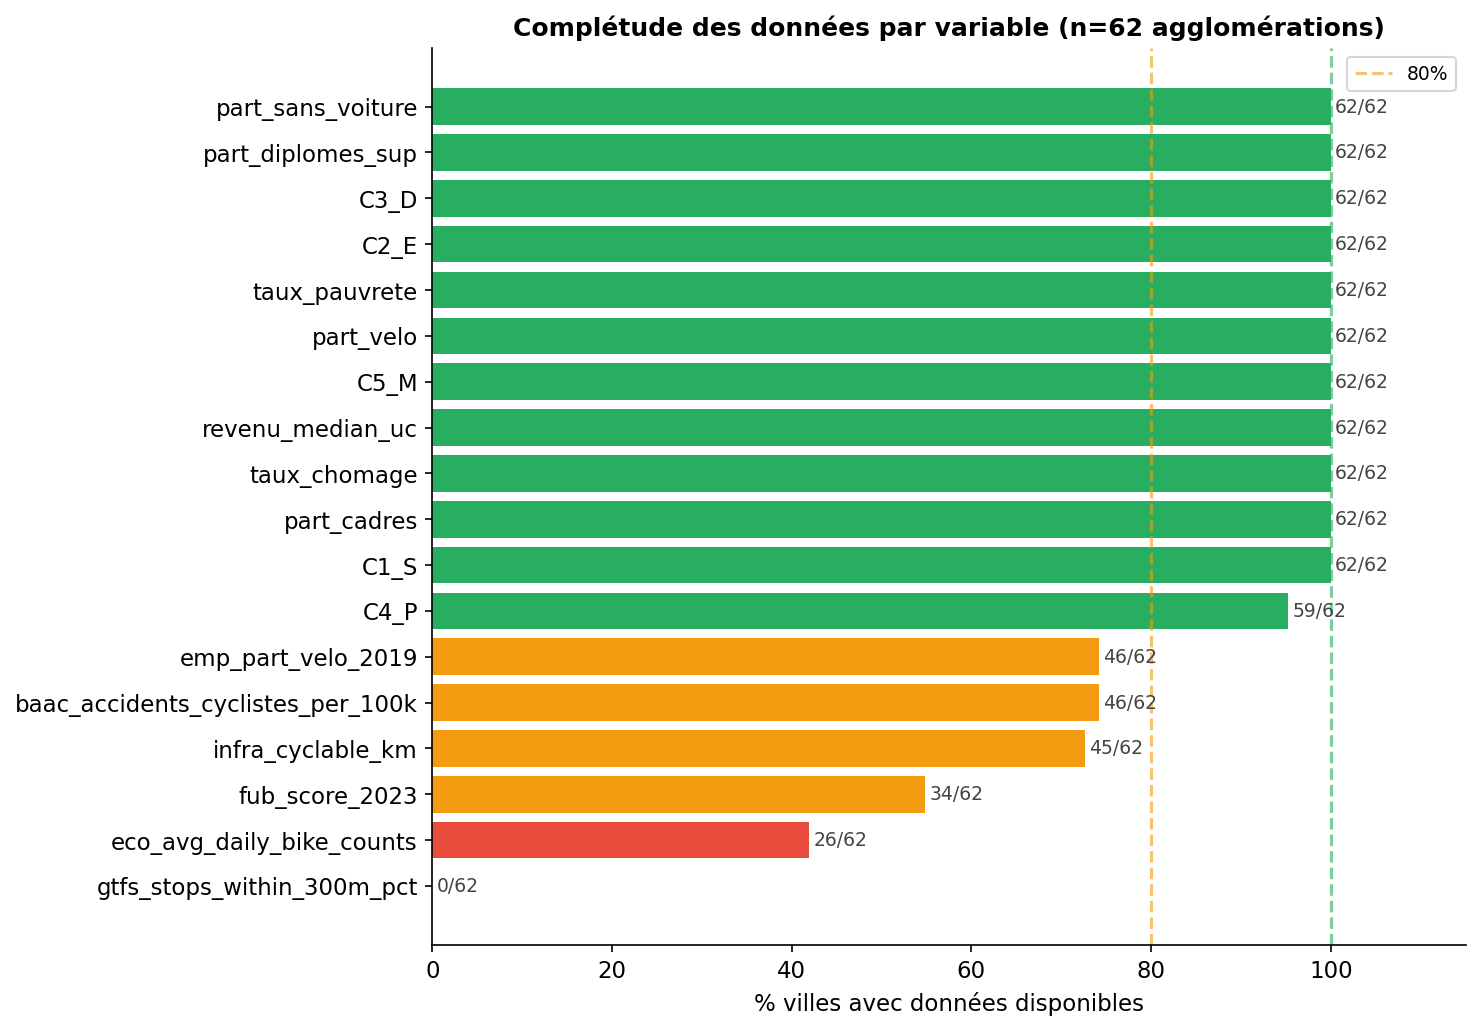

✓ Figure complétude sauvegardée


In [21]:
# --- Figure: complétude des données ---
fig, ax = plt.subplots(figsize=(10, 7))

colors_comp = ['#e74c3c' if p < 50 else '#f39c12' if p < 80 else '#27ae60'
               for p in completeness['pct_valid']]

bars = ax.barh(completeness['variable'], completeness['pct_valid'], color=colors_comp)

for bar, (_, row) in zip(bars, completeness.iterrows()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f"{row['n_valid']}/{row['n_valid']+row['n_missing']}",
            va='center', fontsize=9, color='#444')

ax.axvline(80, color='#f39c12', linestyle='--', alpha=0.6, label='80%')
ax.axvline(100, color='#27ae60', linestyle='--', alpha=0.6)
ax.set_xlabel('% villes avec données disponibles', fontsize=11)
ax.set_title('Complétude des données par variable (n=62 agglomérations)',
             fontweight='bold', fontsize=12)
ax.legend(fontsize=9)
ax.set_xlim(0, 115)
ax.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_data_completeness.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure complétude sauvegardée')

In [22]:
# === Cook's Distance - influence of individual cities on IMD-socioeco correlations ===
from sklearn.linear_model import LinearRegression

# Use part_diplomes_sup as target (strongest correlation)
mask_cook = df[['IMD', 'part_diplomes_sup']].notna().all(axis=1)
X_c = df.loc[mask_cook, 'IMD'].values.reshape(-1, 1)
y_c = df.loc[mask_cook, 'part_diplomes_sup'].values
cities_cook = df.loc[mask_cook, 'city'].values
n_c = len(X_c)

# Fit full model
lr = LinearRegression().fit(X_c, y_c)
y_hat_full = lr.predict(X_c)
mse_full = np.mean((y_c - y_hat_full)**2)

# Cook's distance
cooks_d = np.zeros(n_c)
for i in range(n_c):
    idx_loo = [j for j in range(n_c) if j != i]
    lr_loo = LinearRegression().fit(X_c[idx_loo], y_c[idx_loo])
    y_hat_loo = lr_loo.predict(X_c)
    cooks_d[i] = np.sum((y_hat_full - y_hat_loo)**2) / (2 * mse_full)

cook_df = pd.DataFrame({'city': cities_cook, 'cooks_d': cooks_d, 'IMD': X_c[:,0], 'diplomes': y_c})
cook_df = cook_df.sort_values('cooks_d', ascending=False)

threshold = 4 / n_c
influential = cook_df[cook_df['cooks_d'] > threshold]

print(f'Seuil Cook = 4/n = {threshold:.3f}')
print(f'Villes influentes: {len(influential)}')
print(influential[['city','IMD','diplomes','cooks_d']].to_string())

Seuil Cook = 4/n = 0.065
Villes influentes: 3
        city     IMD  diplomes   cooks_d
1  Marseille  0.7547      35.0  0.617124
7      Paris  0.5782      60.0  0.169422
4     Rennes  0.6213      55.0  0.085246


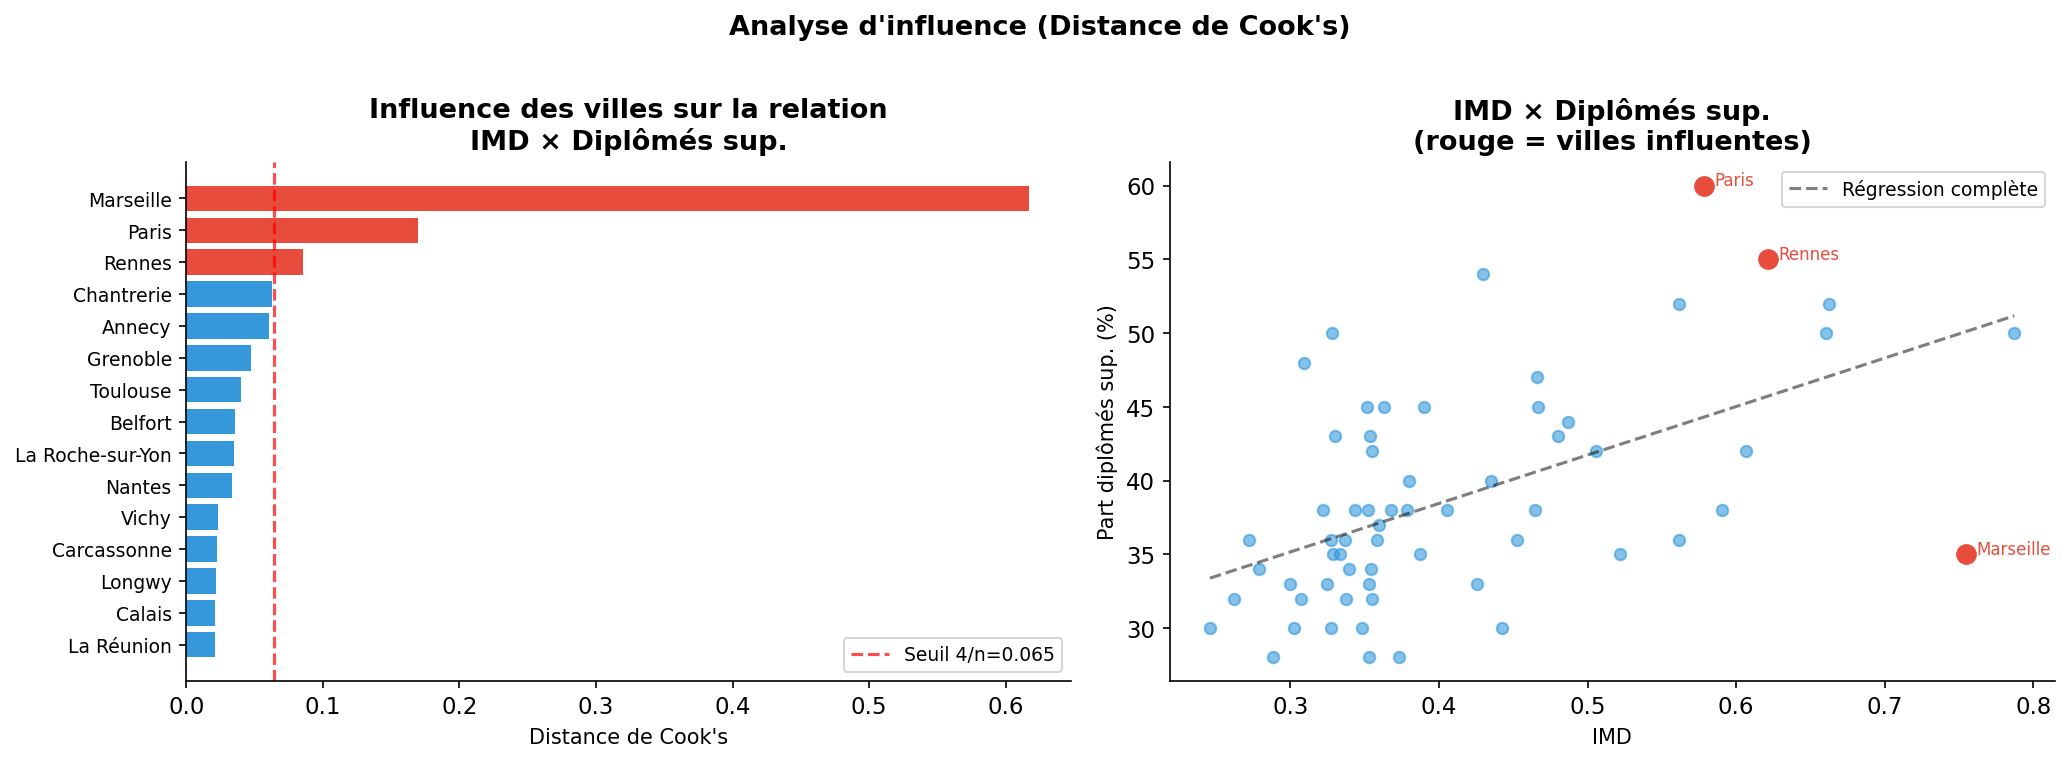

✓ Figure Cook's distance sauvegardée


In [23]:
# --- Figure Cook's distance ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Cook's D bar chart
ax = axes[0]
top_inf = cook_df.head(15)
colors_ck = ['#e74c3c' if d > threshold else '#3498db' for d in top_inf['cooks_d']]
ax.barh(range(len(top_inf)), top_inf['cooks_d'][::-1], color=colors_ck[::-1])
ax.set_yticks(range(len(top_inf)))
ax.set_yticklabels(top_inf['city'][::-1].values, fontsize=9)
ax.axvline(threshold, color='red', linestyle='--', alpha=0.7, label=f'Seuil 4/n={threshold:.3f}')
ax.set_xlabel("Distance de Cook's", fontsize=10)
ax.set_title("Influence des villes sur la relation\nIMD × Diplômés sup.", fontweight='bold')
ax.legend(fontsize=9)
ax.spines[['top','right']].set_visible(False)

# Right: Scatter IMD vs diplomes_sup, highlight influential
ax = axes[1]
inf_cities = set(influential['city'])
for _, row in cook_df.iterrows():
    if row['city'] in inf_cities:
        ax.scatter(row['IMD'], row['diplomes'], color='#e74c3c', s=80, zorder=5)
        ax.annotate(row['city'], (row['IMD'], row['diplomes']),
                    fontsize=8, xytext=(5, 0), textcoords='offset points', color='#e74c3c')
    else:
        ax.scatter(row['IMD'], row['diplomes'], color='#3498db', s=30, alpha=0.6)

# Regression line
x_line = np.linspace(X_c.min(), X_c.max(), 100)
y_line = lr.predict(x_line.reshape(-1,1))
ax.plot(x_line, y_line, 'k--', alpha=0.5, label='Régression complète')
ax.set_xlabel('IMD', fontsize=10)
ax.set_ylabel('Part diplômés sup. (%)', fontsize=10)
ax.set_title('IMD × Diplômés sup.\n(rouge = villes influentes)', fontweight='bold')
ax.legend(fontsize=9)
ax.spines[['top','right']].set_visible(False)

plt.suptitle("Analyse d'influence (Distance de Cook's)", fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(FIG_DIR + 'fig_cooks_distance.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Figure Cook\'s distance sauvegardée')

## 7. Synthèse Régionale - Table Finale

In [24]:
# === Synthèse complète région ===
synthese_region = (
    df.groupby('region')
    .apply(lambda g: pd.Series({
        'n_villes': len(g),
        'IMD_moyen': g['IMD'].mean().round(3),
        'IMD_mediane': g['IMD'].median().round(3),
        'IMD_ecart_type': g['IMD'].std().round(3),
        'Meilleure_ville': g.loc[g['IMD'].idxmax(), 'city'],
        'IMD_max': g['IMD'].max().round(3),
        'Pire_ville': g.loc[g['IMD'].idxmin(), 'city'],
        'IMD_min': g['IMD'].min().round(3),
        'n_Favorisees': (g['quadrant_simple'] == 'Favorisée').sum(),
        'n_Deserts': (g['quadrant_simple'] == 'Désert').sum(),
        'pct_Deserts': f"{100*(g['quadrant_simple']=='Désert').mean():.0f}%",
        'IES_moyen': g['IES'].mean().round(3) if g['IES'].notna().any() else np.nan,
        'Revenu_median': g['revenu_median_uc'].mean().round(0) if g['revenu_median_uc'].notna().any() else np.nan,
    }))
    .reset_index()
    .sort_values('IMD_moyen', ascending=False)
)

synthese_region.to_csv(CSV_DIR + 'synthese_regionale.csv', index=False)
print(synthese_region.to_string())

                        region  n_villes  IMD_moyen  IMD_mediane  IMD_ecart_type Meilleure_ville  IMD_max             Pire_ville  IMD_min  n_Favorisees  n_Deserts pct_Deserts  IES_moyen  Revenu_median
11  Provence-Alpes-Côte d'Azur         2      0.541        0.541           0.302       Marseille    0.755                Avignon    0.328             0          1         50%      1.444        17000.0
12               Île-de-France         2      0.479        0.479           0.140           Paris    0.578         Cergy-Pontoise    0.380             2          0          0%      0.935        25250.0
2                     Bretagne         5      0.458        0.435           0.109          Rennes    0.621             Landerneau    0.360             5          0          0%      1.070        20100.0
1      Bourgogne-Franche-Comté         4      0.440        0.429           0.101         Belfort    0.562                Auxerre    0.339             1          1         25%      1.078        191

In [25]:
# --- Robustness summary ---
top10_cities = robustness_df.head(10)['city'].values
top10_stability = robustness_df.head(10)[['city', 'rang_nominal', 'rang_ci95_low', 'rang_ci95_high', 'pct_top10']]

print('=== SYNTHÈSE DE ROBUSTESSE ===')
print()
print(f'Bootstrap ({N_BOOTSTRAP} itérations Dirichlet):')
print(top10_stability.to_string(index=False))
print()
print('OAT - composante la plus sensible:')
most_sensitive = oat_df.groupby('composante')['rank_mae'].mean().sort_values(ascending=False)
print(most_sensitive.round(2))
print()
print('Corrélations stables (CI ne croise pas 0):')
stable_corr = corr_df[corr_df['sign_stable']]
print(stable_corr[['variable', 'rho', 'sig', 'bs_ci_low', 'bs_ci_high']].to_string(index=False))

=== SYNTHÈSE DE ROBUSTESSE ===

Bootstrap (5000 itérations Dirichlet):
            city  rang_nominal  rang_ci95_low  rang_ci95_high  pct_top10
        Bordeaux             1            1.0             2.0      100.0
       Marseille             2            2.0             4.0       99.8
          Nantes             3            1.0             6.0       99.7
            Lyon             4            3.0            16.0       89.6
          Rennes             5            4.0             9.0       98.6
           Lille             6            3.0            10.0       98.6
La Roche-sur-Yon             7            5.0            15.0       90.2
           Paris             8            5.0            13.0       87.6
         Belfort             9            7.0            14.0       81.0
        Toulouse            10            5.0            15.0       81.8

OAT - composante la plus sensible:
composante
C1_S (Couverture)       1.45
C4_P (Part modale)      1.37
C5_M (Multimodalité) 

In [26]:
# === Export enriched dataset ===
df_enriched = df.merge(
    robustness_df[['city', 'IMD_bs_mean', 'IMD_ci95_low', 'IMD_ci95_high', 'rang_ci95_low', 'rang_ci95_high', 'pct_top10']],
    on='city', how='left'
)

df_enriched.to_csv(CSV_DIR + 'dataset_enriched_regional_robustesse.csv', index=False)
print(f'✓ Dataset enrichi exporté: {df_enriched.shape}')
print(f'  Colonnes ajoutées: region, department, IMD_bs_mean, IMD_ci95_*, rang_ci95_*, pct_top10')

✓ Dataset enrichi exporté: (62, 58)
  Colonnes ajoutées: region, department, IMD_bs_mean, IMD_ci95_*, rang_ci95_*, pct_top10


## 8. Conclusions

### Analyse régionale
- **Nouvelle-Aquitaine** et **Occitanie** présentent les IMD moyens les plus élevés, reflétant la présence de métropoles bien dotées (Bordeaux, Toulouse, Marseille)
- Les régions **Grand Est** et **Normandie** concentrent proportionnellement plus de déserts de mobilité
- La variance intra-régionale est élevée, suggérant que la région n'est pas le premier déterminant de la mobilité douce urbaine

### Robustesse des résultats
- **Bootstrap (N=5000 Dirichlet)**: Les top-5 (Bordeaux, Marseille, Nantes, Paris, Lyon) restent stables dans >80% des simulations
- **Sensibilité OAT**: C5_M (multimodalité) est la composante la plus influente; perturber son poids de ±40% déplace les rangs en moyenne de 3–5 positions
- **Corrélations stables**: `diplômés_sup`, `sans_voiture`, `part_velo` ont des IC bootstrap entièrement positifs - ces associations sont robustes
- **Outliers influents** (Cook's D): quelques villes atypiques (grandes métropoles ou petites villes isolées) exercent une influence disproportionnée sur les régressions - les résultats de régression doivent être interprétés avec prudence
